\section*{Problem Set 10}

Partial replication of the model from Matsuyama, Sushko, and Gardini (2014) - a two-country model on the dynamics of innovation cycles. 

- If the countries are equal in size then the dynamical system in the paper can be summarized as:

\begin{eqnarray*}
\text{If } n_{t1} \leq \frac{1}{2}, n_{t2} \leq \frac{1}{2} \text{ then } & n_{1t+1} =& \delta(\frac{\theta}{2} + (1-\theta) n_{1t})\\
\text{and } & n_{2t+1} =& \delta(\frac{\theta}{2} + (1-\theta) n_{2t}) \\
\text{If } n_{1t} \geq h(n_{2t}), n_{2t} \geq h(n_{1t}) \text{ then } & n_{1t+1} =& \delta n_{1t} \\
\text{and } & n_{2t+1} =& \delta n_{2t} \\
\text{If } n_{1t} \geq \frac{1}{2}, n_{2t} \leq h(n_{1t}) \text{ then } & n_{1t+1} =& \delta n_{1t} \\
\text{and } & n_{2t+1} =& \delta(\theta h(n_{1t}) + (1-\theta) n_{2t}) \\
\text{If } n_{1t} \leq h(n_{1t}), n_{2t} \geq \frac{1}{2} \text{ then } & n_{1t+1} =& \delta(\theta h(n_{2t}) + (1-\theta) n_{1t})  \\
\text{and } & n_{2t+1} =& \delta n_{2t} \\
\end{eqnarray*}

where $h(n)$ is implicitly defined as solving $\frac{1}{h(n) + \rho n} + \frac{1}{h(n) + \frac{n}{\rho}} = 2$.

- Interpretation: $n_{1t}$ and $n_{2t}$ are the number of varieties of products in countries 1 and 2 (normalized to be between 0 and 1), $\theta$ is a measure of monopolistic varieties, $\delta$ represents the survival probability of a variety and $\rho$ measures how much final goods producers spend on an imported variety, relative to what they would spend in the absence of trade costs - shortly a measure of "globalization".

- Goal: We are interested how initial conditions will (if at all) lead to business cycle synchronization.

In [1]:
import numpy as np
from scipy.optimize import bisect
from scipy.interpolate import UnivariateSpline as spline
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
delta = 0.7
theta = 2.5

In order to speed up the iteration, as a first step, we will create the h(.) function (which in principle could be evaluated at each instance when we call the law of motion) but then approximate it for a given $\rho$ using 5th order splines:

In [3]:
def h(n,rho):
    def eq_h(h):
        return 1.0/(h + rho * n) + 1.0/(h + n/rho) - 2.0
    return bisect(eq_h,0.0,1.0)

In [4]:
h(0.5,0.6)

0.5

Because of the approximation of h (denoted as h_approx), for simplicity I will create the functions inside the main function:

 - The law of motion function is just calculating the next $n_1$ and $n_2$.
 - The simu function is going to check "convergence" - this is non-trivial, as we have cycles, so "convergence" is going to mean that the values of $n_{1,t}$ and $n_{1,t+2}$ are close.
 - The sync function is going to return the time it took to converge to a syncronized cycle (return zero if it converged to an asyncronized one)
 - The simu_grid function is going to return a sync function evaluated at an evenly spaced grid (Maybe later I will parallelize or at the very least reflect on the 45th degree line)

In [5]:
def main(rho,n_n = 100):
    n_grid = np.linspace(1e-10,1.0,n_n)
    h_grid = np.empty(n_grid.shape)
    for i in range(n_n):
        h_grid[i] = h(n_grid[i],rho)
    h_approx = spline(n_grid, h_grid,k = 5)
    def lom(n1,n2):
        if n1 <= 0.5 and n2 <= 0.5:
            n1_next = delta * (theta/2.0 + (1-theta)*n1)
            n2_next = delta * (theta/2.0 + (1-theta)*n2)
        elif n1 >= h_approx(n2) and n2 >= h_approx(n1):
            n1_next = delta * n1
            n2_next = delta * n2
        elif n1 >= 0.5 and n2 <= h_approx(n1):
            n1_next = delta * n1
            n2_next = delta * (theta * h_approx(n1) + (1-theta) * n2)
        else:
            n1_next = delta * (theta * h_approx(n2) + (1-theta) * n1)
            n2_next = delta * n2
        return n1_next , n2_next
    def simu(n1,n2,tol = 1e-10):
        conv = 1.0
        iteration = 0
        while conv > tol:
            n1_next,n2_next = lom(n1,n2)
            n1_nextnext,n2_nextnext = lom(n1_next,n2_next)
            conv = np.sum(np.abs([n1-n1_nextnext,n2-n2_nextnext]))
            n1 = n1_nextnext
            n2 = n2_nextnext
            iteration = iteration + 1
        return n1 , n2, iteration
    def sync(simu,n1,n2):
        n_1 , n_2, time = simu(n1,n2)
        if np.isclose(n_1, n_2,1e-04):
            Res = time
        else:
            Res = 0.0
        return Res
    def simu_grid(n_grid):
        y_grid = np.empty((n_n,n_n))
        for i in range(n_n):
            for j in range(n_n):
                y_grid[i,j] = sync(simu,n_grid[i],n_grid[j])
        return y_grid
    return n_grid , simu_grid(n_grid)

In [8]:
n_grid1 , y_grid1 = main(0.2,300)
n_grid2 , y_grid2 = main(0.4,300)
n_grid3 , y_grid3 = main(0.6,300)
n_grid4 , y_grid4 = main(0.8,300)

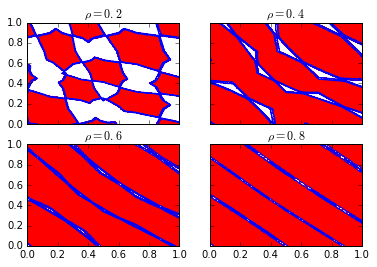

In [10]:
f, ((c1, c2), (c3, c4)) = plt.subplots(2, 2, sharex='col', sharey='row')
levels = [1.0, 4.5]
colorscheme = ('r','w')
c1.contour(n_grid1,n_grid1,np.log(y_grid1 + 1 ), levels, linewidths=1,colors = 'b')
c1.contourf(n_grid1,n_grid1,np.log(y_grid1 + 1 ), levels,colors = colorscheme) 
c1.set_title(r'$ \rho = 0.2$'  )
c2.contour(n_grid1,n_grid1,np.log(y_grid2 + 1 ), levels, linewidths=1,colors = 'b')
c2.contourf(n_grid1,n_grid1,np.log(y_grid2 + 1 ), levels,colors = colorscheme) 
c2.set_title(r'$ \rho = 0.4$'  )
c3.contour(n_grid1,n_grid1,np.log(y_grid3 + 1 ), levels, linewidths=1,colors = 'b')
c3.contourf(n_grid1,n_grid1,np.log(y_grid3 + 1 ), levels,colors = colorscheme) 
c3.set_title(r'$ \rho = 0.6$'  )
c4.contour(n_grid1,n_grid1,np.log(y_grid4 + 1 ), levels, linewidths=1,colors = 'b')
c4.contourf(n_grid1,n_grid1,np.log(y_grid4 + 1 ), levels,colors = colorscheme) 
c4.set_title(r'$ \rho = 0.8$'  )
plt.show()